## Import libraries

In [1]:
import os
import glob
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, floor

from scipy.stats import chi2

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

## Utilities

In [2]:
def inject_fixed_mahalanobis_outliers(X, y, contamination_rate=0.01, distance_k=6.0, random_state=42):
    """
    Injects multivariate outliers at a fixed Mahalanobis distance `distance_k`
    from the original data distribution (as measured by mean/cov).
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : np.ndarray
        Target vector of shape (n_samples,).
    contamination_rate : float
        Fraction of points to replace with outliers.
    distance_k : float
        Desired Mahalanobis distance.
    random_state : int or None
        Seed for reproducibility.
    
    Returns
    -------
    X_new, y_new : np.ndarray, np.ndarray
        New feature matrix and target vector with outliers injected.
    """
    rng = np.random.default_rng(random_state)

    n_samples, n_features = X.shape
    num_outliers = int(np.ceil(n_samples * contamination_rate))
    
    if num_outliers == 0:
        return X, y
    
    # Compute mean and covariance of the original data
    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False)  # shape: (n_features, n_features)
    
    # Cholesky decomposition for the data's covariance
    U = np.linalg.cholesky(cov)  # shape: (n_features, n_features)

    # Generate outliers, each at distance_k from mu
    X_outliers = []
    for _ in range(num_outliers):
        # Draw random vector from N(0, I)
        y_rand = rng.normal(size=n_features)
        
        # Normalize to unit length
        v = y_rand / np.linalg.norm(y_rand)
        
        # Scale to distance_k
        z = distance_k * v  # this is in standardized space
        
        # Transform back: x = mu + U * z
        x_outlier = mu + U @ z
        X_outliers.append(x_outlier)
    
    X_outliers = np.array(X_outliers)
    
    #Randomize the outlier labels from existing distribution
    y_outliers = rng.choice(y, size=num_outliers)
    
    # Randomly choose which points in X to replace
    indices_to_replace = rng.choice(n_samples, size=num_outliers, replace=False)
    
    X_new = X.copy()
    y_new = y.copy()
    X_new[indices_to_replace, :] = X_outliers
    y_new[indices_to_replace] = y_outliers

    return X_new, y_new

def parse_filename(filename):
    """
    Extracts (sample_size, contamination) from filenames like:
    'df100.csv' or 'df100_contam5.csv'.
    If the pattern doesn't match, returns (None, None).
    """
    pattern = r"df(\d+)(?:_contam(\d+))?\.csv"
    match = re.search(pattern, filename)
    if not match:
        return None, None
    sample_size = int(match.group(1))
    contam_str = match.group(2)
    contamination = int(contam_str) if contam_str else 0
    return sample_size, contamination

def mahalanobis_distance_sq(X):
    """
    Computes the squared Mahalanobis distance for each row in X.
    Returns an array of shape (n_samples,).
    """
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    # Center the data
    diff = X - mu
    # Mahalanobis distance^2 = (x - mu)^T * inv_cov * (x - mu)
    md_sq = np.diag(diff @ inv_cov @ diff.T)
    return md_sq

def mahalanobis_distance_sq_2d(X2):
    """
    Same as above, but specifically for a 2D array X2.
    """
    mu = np.mean(X2, axis=0)
    cov = np.cov(X2, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    diff = X2 - mu
    md_sq = np.diag(diff @ inv_cov @ diff.T)
    return md_sq

if os.path.isfile("results.csv"):
    existing_results_df = pd.read_csv("results.csv")
else:
    existing_results_df = pd.DataFrame()

# We'll keep a global list to collect new results from each model
new_results_global = []

# Single scoring dictionary (shared by all models)
scoring_dict = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}


## Constructing datasets

### Construct uncontaminated datasets

In [3]:
sample_sizes = [50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for n in sample_sizes:
    # Generate the dataset
    X, y = make_classification(
        n_samples=n,
        n_features=10,
        n_informative=10,  # all features informative
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        random_state=42  
    )
    
    # Create a DataFrame
    df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    df['target'] = y
    
    # Dynamically name the DataFrames
    globals()[f'df{n}'] = df
    
    # Save to CSV
    df.to_csv(f'df{n}.csv', index=False)
    
    print(f"Saved df{n} with shape: {df.shape}")


Saved df50 with shape: (50, 11)
Saved df100 with shape: (100, 11)
Saved df500 with shape: (500, 11)
Saved df1000 with shape: (1000, 11)
Saved df2000 with shape: (2000, 11)
Saved df3000 with shape: (3000, 11)
Saved df4000 with shape: (4000, 11)
Saved df5000 with shape: (5000, 11)
Saved df6000 with shape: (6000, 11)
Saved df7000 with shape: (7000, 11)
Saved df8000 with shape: (8000, 11)
Saved df9000 with shape: (9000, 11)
Saved df10000 with shape: (10000, 11)


### Inject outliers into each sample 

In [4]:
contamination_rates = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

for n in sample_sizes:
    # Load uncontaminated dataset
    df = pd.read_csv(f"df{n}.csv")
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    for c in contamination_rates:
        # Inject outliers at 6 stdev distance
        X_new, y_new = inject_fixed_mahalanobis_outliers(
            X, y,
            contamination_rate=c,
            distance_k=6.0,
            random_state=42
        )

        # Create new DataFrames
        df_new = pd.DataFrame(X_new, columns=[f"feature_{i}" for i in range(X_new.shape[1])])
        df_new["target"] = y_new

        # Build a new files
        c_percent = int(c * 1000)
        fname = f"df{n}_contam{c_percent}.csv"
        df_new.to_csv(fname, index=False)

        print(f"Saved contaminated dataset {fname} with shape: {df_new.shape}")

all_csv_files = glob.glob("df*.csv")


Saved contaminated dataset df50_contam5.csv with shape: (50, 11)
Saved contaminated dataset df50_contam10.csv with shape: (50, 11)
Saved contaminated dataset df50_contam20.csv with shape: (50, 11)
Saved contaminated dataset df50_contam30.csv with shape: (50, 11)
Saved contaminated dataset df50_contam40.csv with shape: (50, 11)
Saved contaminated dataset df50_contam50.csv with shape: (50, 11)
Saved contaminated dataset df50_contam60.csv with shape: (50, 11)
Saved contaminated dataset df50_contam70.csv with shape: (50, 11)
Saved contaminated dataset df50_contam80.csv with shape: (50, 11)
Saved contaminated dataset df50_contam90.csv with shape: (50, 11)
Saved contaminated dataset df50_contam100.csv with shape: (50, 11)
Saved contaminated dataset df100_contam5.csv with shape: (100, 11)
Saved contaminated dataset df100_contam10.csv with shape: (100, 11)
Saved contaminated dataset df100_contam20.csv with shape: (100, 11)
Saved contaminated dataset df100_contam30.csv with shape: (100, 11)
Sav

## Visualize the data

### First two principal components

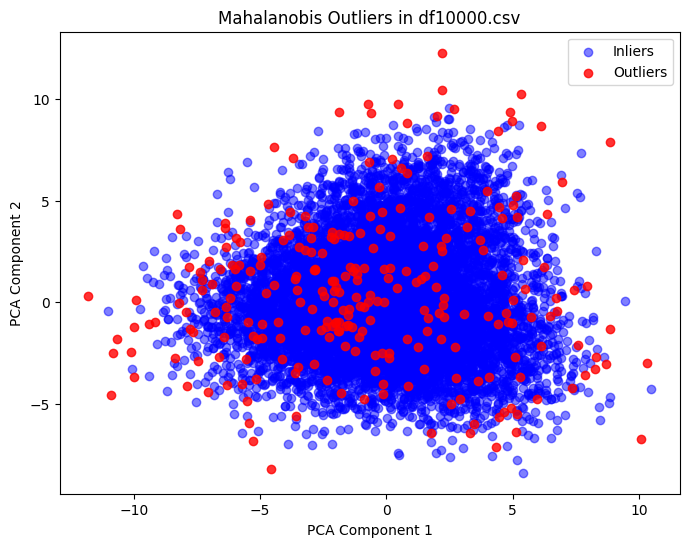

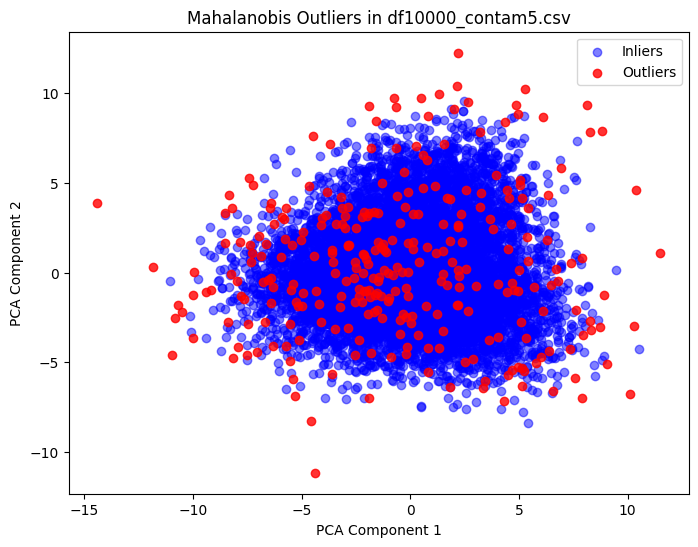

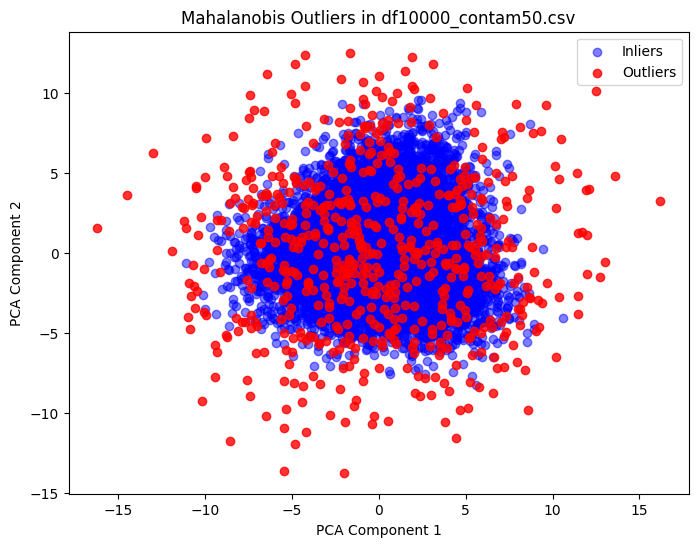

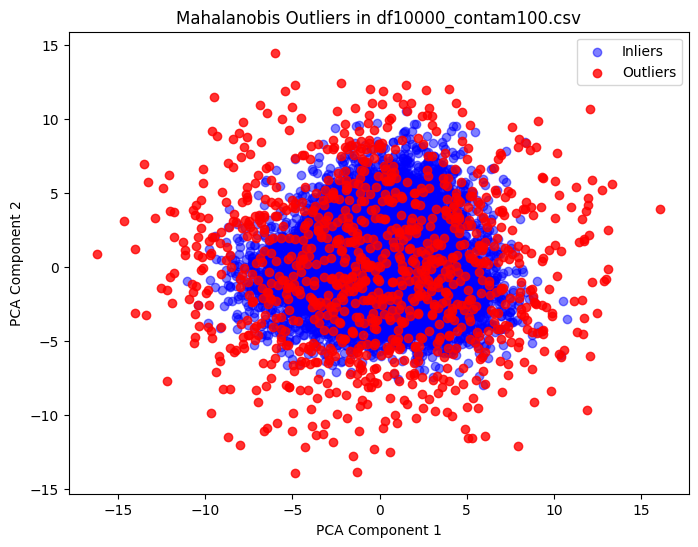

In [5]:
# Choose n=10,000 and contamination rates 5%, 50%, and 100% for visualization
files = [
    "df10000.csv",
    "df10000_contam5.csv",
    "df10000_contam50.csv",
    "df10000_contam100.csv",    

]

# Choose a chi-square cutoff for outliers (99% quantile)
alpha = 0.99

for fname in files:
    # Read the dataset
    df = pd.read_csv(fname)
    
    # The last column is target, so only use features for Mahalanobis & PCA
    X = df.iloc[:, :-1].values
    
    # Compute squared Mahalanobis distance for each point
    md_sq = mahalanobis_distance_sq(X)
    
    # Determine a threshold based on chi-square distribution
    dof = X.shape[1]  # degrees of freedom = number of features
    chi2_threshold = chi2.ppf(alpha, dof)
    
    # Identify outliers
    outlier_mask = md_sq > chi2_threshold  # (True = outlier)
    
    # Apply PCA to get 2D representation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.title(f"Mahalanobis Outliers in {fname}")
    
    # Inliers in blue
    plt.scatter(
        X_pca[~outlier_mask, 0],
        X_pca[~outlier_mask, 1],
        c='blue', alpha=0.5, label='Inliers'
    )
    # Outliers in red
    plt.scatter(
        X_pca[outlier_mask, 0],
        X_pca[outlier_mask, 1],
        c='red', alpha=0.8, label='Outliers'
    )
    
    plt.legend()
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


### Pairplot

In [ ]:
files = [
    "df10000.csv",
    "df10000_contam5.csv",
    "df10000_contam50.csv",
    "df10000_contam100.csv",
]

chi2_threshold_2d_99 = chi2.ppf(0.99, df=10)

for fname in files:
    df = pd.read_csv(fname)    
    # Compute 2D Mahalanobis distance
    md_sq = mahalanobis_distance_sq_2d(df.values)
    outlier_mask = md_sq > chi2_threshold_2d_99
    
    # Label outliers in a new column
    df["Outlier"] = np.where(outlier_mask, "Yes", "No")
    
    # Pairplot
    g = sns.pairplot(
        data=df,
        hue="Outlier",
        diag_kind="hist",
        corner=False,         
        plot_kws={"alpha": 0.5}
)

    g.fig.suptitle(f"Pairplot (Mahalanobis Outliers) for {fname}", y=1.02)
    plt.show()



## Modelling

### XGBoost

In [7]:
new_results_xgb=[]

# Loop over all CSV files
for csv_file in all_csv_files:
    n, c = parse_filename(csv_file)
    if n is None:
        continue

    # Load the dataset
    df = pd.read_csv(csv_file)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    # Create an XGBoost classifier with logloss as the evaluation metric
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    
    # Cross-validate with 10 folds
    cv_results = cross_validate(
        model, X, y,
        cv=10,
        scoring=scoring_dict,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Compute the mean of each metric
    avg_accuracy = np.mean(cv_results['test_accuracy'])
    avg_precision = np.mean(cv_results['test_precision'])
    avg_recall = np.mean(cv_results['test_recall'])
    misclassification_rate = 1.0 - avg_accuracy
    
    # Append
    new_results_xgb.append({
        'model': 'XGBoost',
        'sample size (n)': n,
        'contamination': c,
        'precision': avg_precision,
        'recall': avg_recall,
        'accuracy': avg_accuracy,
        'misclassification rate': misclassification_rate
    })

new_results_df = pd.DataFrame(new_results_xgb)

new_results_global.extend(new_results_xgb)

print("XGBoost done. Local results added to new_results_global.")


/Users/khalidalq/Documents/vs_code_files/401/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/khalidalq/Documents/vs_code_files/401/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost done. Local results added to new_results_global.


### RandomForest

In [8]:
new_results_rf=[]


# Loop over all CSV files and fit Random Forest
for csv_file in all_csv_files:
    n, c = parse_filename(csv_file)
    if n is None:
        continue  # skip files that don't match the pattern
    
    # Load dataset
    df = pd.read_csv(csv_file)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    # Create a Random Forest classifier
    model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1
    )
    
    # 10-fold cross-validation
    cv_results = cross_validate(
        model, X, y,
        cv=10,
        scoring=scoring_dict,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Compute the mean metrics
    avg_accuracy = np.mean(cv_results['test_accuracy'])
    avg_precision = np.mean(cv_results['test_precision'])
    avg_recall = np.mean(cv_results['test_recall'])
    misclassification_rate = 1.0 - avg_accuracy
    
    # Append
    new_results_rf.append({
        'model': 'RandomForest',
        'sample size (n)': n,
        'contamination': c,
        'precision': avg_precision,
        'recall': avg_recall,
        'accuracy': avg_accuracy,
        'misclassification rate': misclassification_rate
    })

new_results_df = pd.DataFrame(new_results_rf)

new_results_global.extend(new_results_rf)

print("Random Forest metrics appended to new_results_global.")


Random Forest metrics appended to new_results_global.


### Logistic Regression

In [9]:
new_results_lr=[]



# Loop over all CSV files for Logistic Regression
for csv_file in all_csv_files:
    n, c = parse_filename(csv_file)
    if n is None:
        continue
    
    # Load dataset
    df = pd.read_csv(csv_file)
    X = df.iloc[:, :-1].values 
    y = df.iloc[:, -1].values  
    
    # Create a Logistic Regression model
    model = LogisticRegression(max_iter=1000, random_state=42)
    
    # 10-fold cross-validation
    cv_results = cross_validate(
        model, X, y,
        cv=10,
        scoring=scoring_dict,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Compute mean metrics
    avg_accuracy = np.mean(cv_results['test_accuracy'])
    avg_precision = np.mean(cv_results['test_precision'])
    avg_recall = np.mean(cv_results['test_recall'])
    misclassification_rate = 1.0 - avg_accuracy
    
    # Add a row to our list
    new_results_lr.append({
        'model': 'LogisticRegression',
        'sample size (n)': n,
        'contamination': c,
        'precision': avg_precision,
        'recall': avg_recall,
        'accuracy': avg_accuracy,
        'misclassification rate': misclassification_rate
    })

new_results_df = pd.DataFrame(new_results_lr)

new_results_global.extend(new_results_lr)

print("Logistic Regression metrics appended to new_results_global.")


Logistic Regression metrics appended to new_results_global.


### SVM with rbf kernel

In [10]:
new_results_svm=[]


# Loop over all CSV files for SVM with RBF kernel
for csv_file in all_csv_files:
    n, c = parse_filename(csv_file)
    if n is None:
        continue  # skip files that don't match pattern
    
    # Load dataset
    df = pd.read_csv(csv_file)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    # Create an SVM classifier with RBF kernel
    # C=1.0 is the regularization parameter; gamma='scale' is default (1 / (n_features * X.var()))
    model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    
    # 10-fold cross-validation
    cv_results = cross_validate(
        model, X, y,
        cv=10,
        scoring=scoring_dict,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Compute mean metrics
    avg_accuracy = np.mean(cv_results['test_accuracy'])
    avg_precision = np.mean(cv_results['test_precision'])
    avg_recall = np.mean(cv_results['test_recall'])
    misclassification_rate = 1.0 - avg_accuracy
    
    # Add a row
    new_results_svm.append({
        'model': 'SVM',
        'sample size (n)': n,
        'contamination': c,
        'precision': avg_precision,
        'recall': avg_recall,
        'accuracy': avg_accuracy,
        'misclassification rate': misclassification_rate
    })

new_results_global.extend(new_results_svm)
print("SVM (RBF) metrics appended to new_results_global.")


SVM (RBF) metrics appended to new_results_global.


### KNN (k=sqrt(n))

In [11]:
new_results_knn = []



# Outer 10-fold CV
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

for csv_file in all_csv_files:
    n, c = parse_filename(csv_file)
    if n is None:
        continue
    
    # Read data
    df = pd.read_csv(csv_file)
    X = df.iloc[:, :-1].values 
    y = df.iloc[:, -1].values 
    n_samples = X.shape[0]
    
    # Store fold-by-fold metrics
    outer_accuracies = []
    outer_precisions = []
    outer_recalls    = []
    
    # Fix k = floor(sqrt(n_samples))
    k = max(1, floor(sqrt(n_samples)))
    
    # Outer loop: 10-fold
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Create a KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Evaluate on the outer test fold
        y_pred = knn.predict(X_test)
        
        # Compute metrics
        fold_accuracy  = accuracy_score(y_test, y_pred)
        fold_precision = precision_score(y_test, y_pred, zero_division=0)
        fold_recall    = recall_score(y_test, y_pred, zero_division=0)

        outer_accuracies.append(fold_accuracy)
        outer_precisions.append(fold_precision)
        outer_recalls.append(fold_recall)

    # Average across the outer folds
    avg_accuracy = np.mean(outer_accuracies)
    avg_precision = np.mean(outer_precisions)
    avg_recall = np.mean(outer_recalls)
    misclassification_rate = 1.0 - avg_accuracy

    # Save a single row with the average performance for this dataset
    new_results_knn.append({
        'model': 'KNN',
        'sample size (n)': n,
        'contamination': c,
        'precision': avg_precision,
        'recall': avg_recall,
        'accuracy': avg_accuracy,
        'misclassification rate': misclassification_rate,
        'chosen_n_neighbors': k
    })

# Append to global results list
new_results_global.extend(new_results_knn)
print("\nKNN (k = floor(sqrt(n))) results appended to new_results_global.")


KNN (k = floor(sqrt(n))) results appended to new_results_global.


### Gather results and save into CSV

In [12]:
# Combine
all_new_df = pd.DataFrame(new_results_global)
combined_df = pd.concat([existing_results_df, all_new_df], ignore_index=True)

# Sort
combined_df.sort_values(by=['sample size (n)', 'contamination'], inplace=True)

# Save
combined_df.to_csv("results.csv", index=False)

print("All results saved to results.csv.")

All results saved to results.csv.


## Plotting results

### Contamination v accuracy, accuracy averaged over n

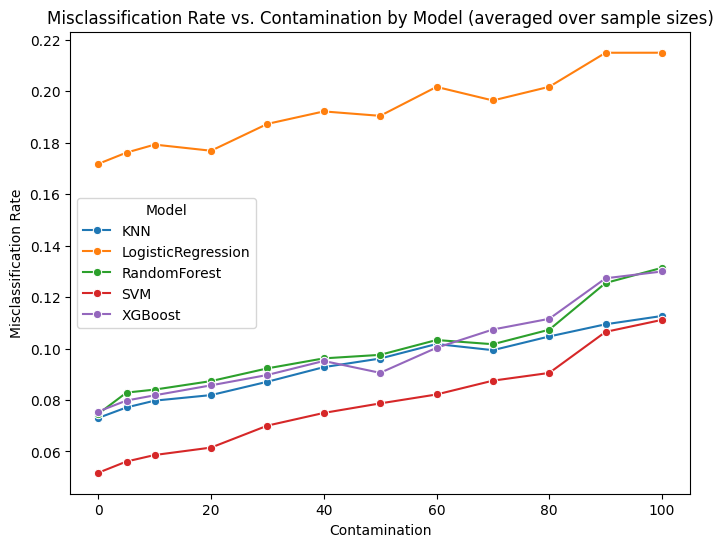

In [13]:
model_order = ["XGBoost", "RandomForest", "LogisticRegression", "SVM", "KNN"]
# Create a color mapping dict:
model_palette = {
    "XGBoost": "blue",
    "RandomForest": "green",
    "LogisticRegression": "orange",
    "SVM": "purple",
    "KNN": "red"
}

df = pd.read_csv("results.csv")

# Average over sample sizes if you have multiple sample sizes
# Grouped by (model, contamination), computing mean accuracy
df_plot = df.groupby(["model", "contamination"], as_index=False)["misclassification rate"].mean()

# 3. Plot with Seaborn lineplot
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df_plot,
    x="contamination",
    y="misclassification rate",
    hue="model",         # one line per model
    marker="o"           # optional: put markers on each data point
)

plt.title("Misclassification Rate vs. Contamination by Model (averaged over sample sizes)")
plt.xlabel("Contamination")
plt.ylabel("Misclassification Rate")
plt.legend(title="Model")
plt.show()

### Contamination vs accuracy (for each n)

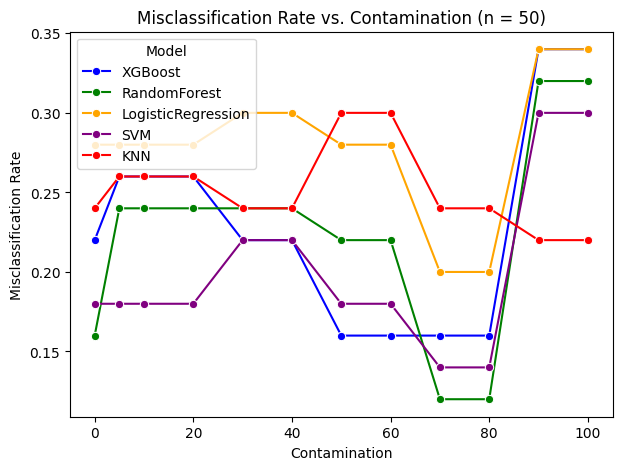

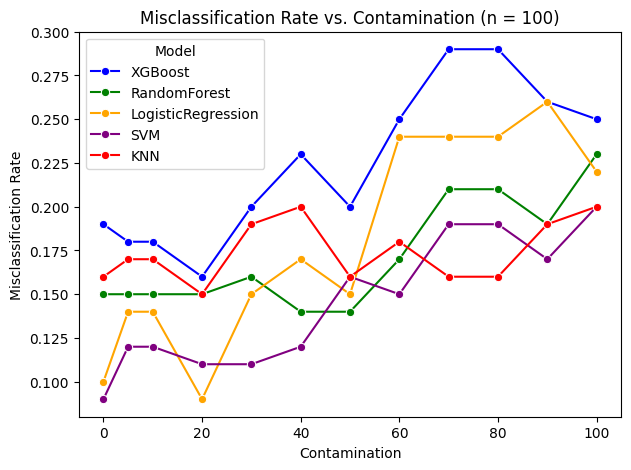

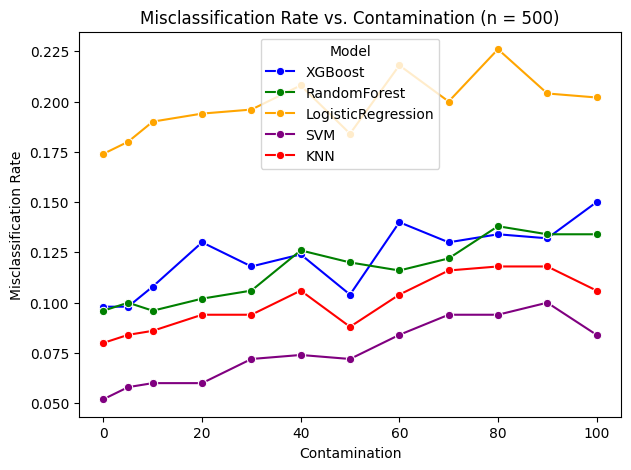

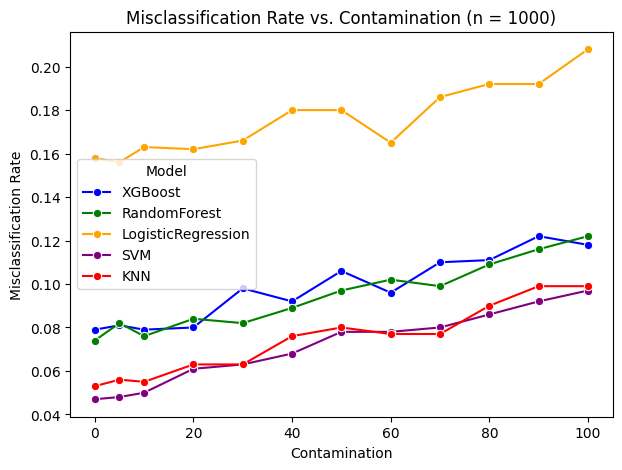

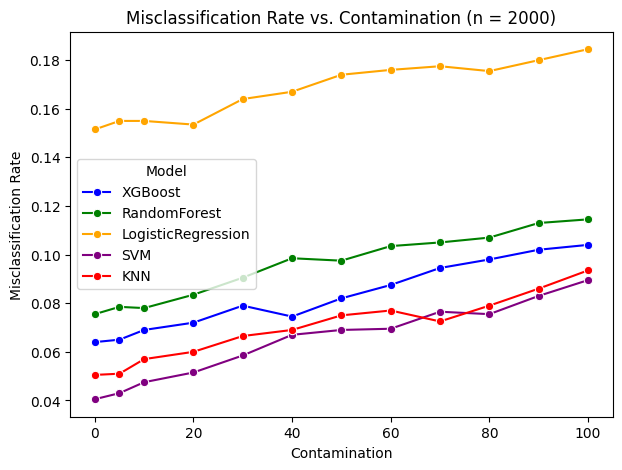

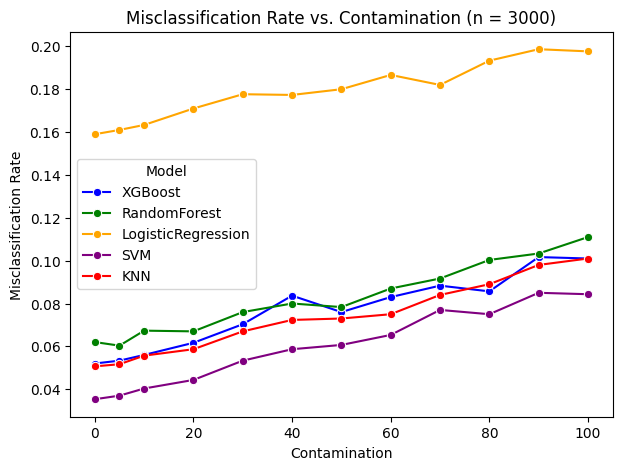

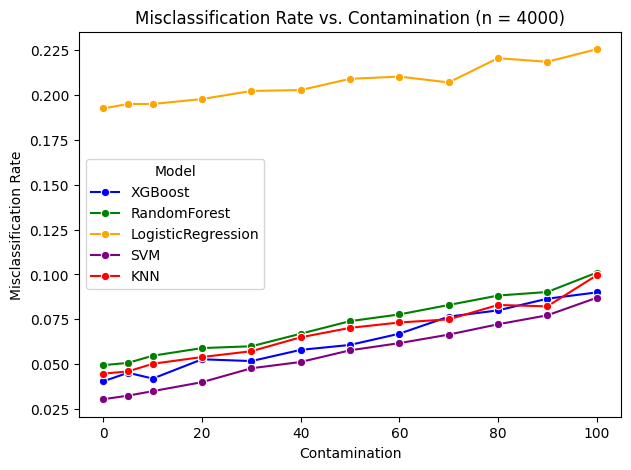

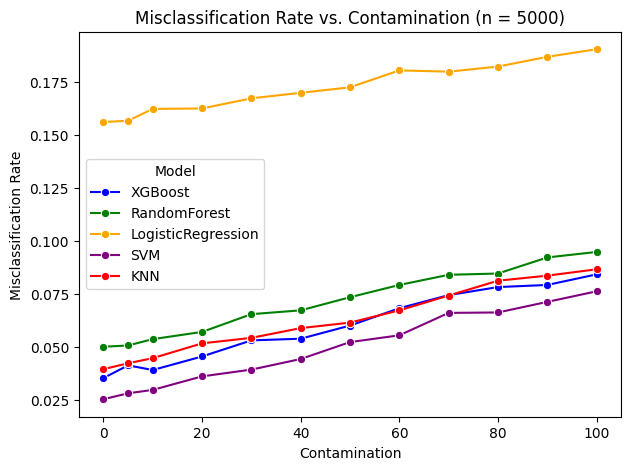

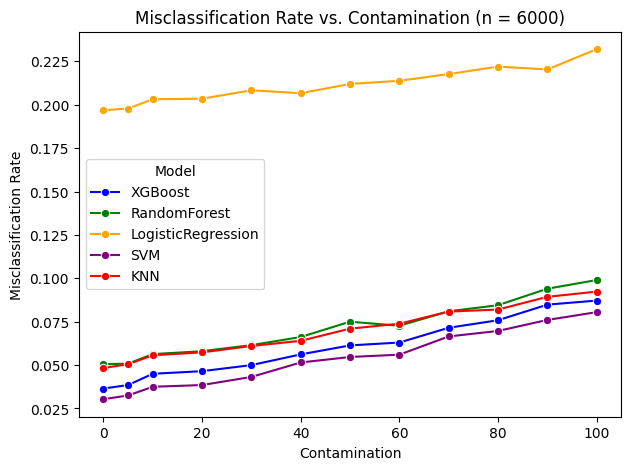

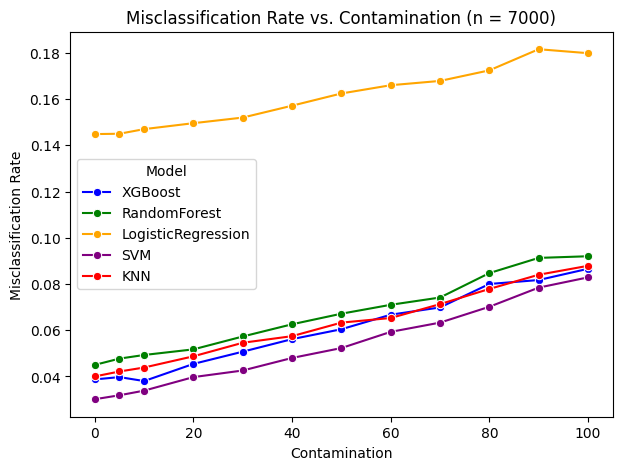

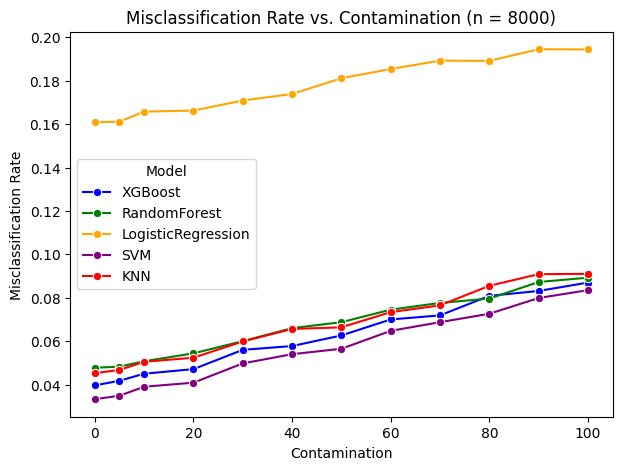

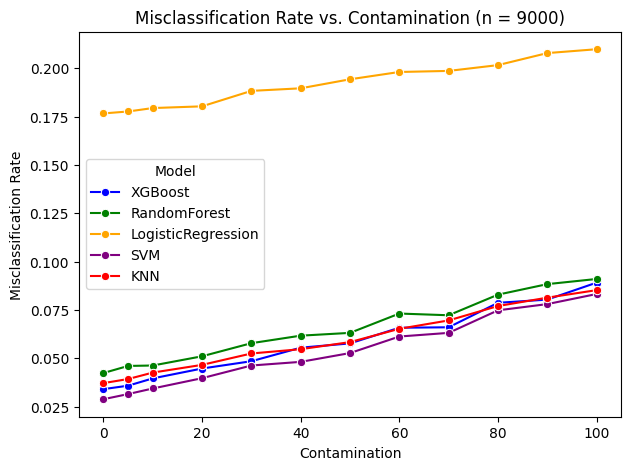

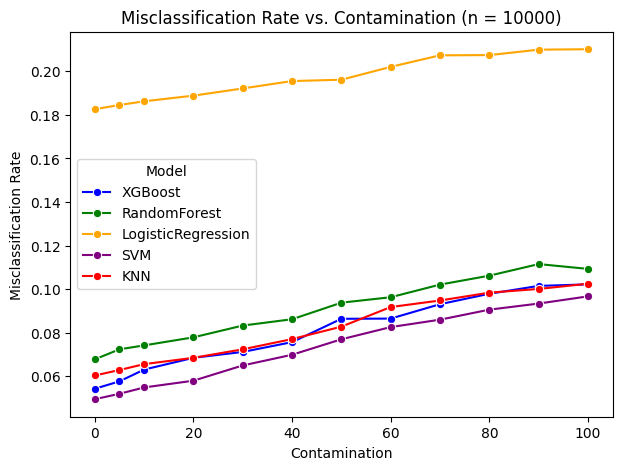

In [14]:
df = pd.read_csv("results.csv")
sample_sizes = sorted(df["sample size (n)"].unique())

for n_val in sample_sizes:
    subset = df[df["sample size (n)"] == n_val]
    
    plt.figure(figsize=(7, 5))
    
    sns.lineplot(
        data=subset,
        x="contamination",
        y="misclassification rate",
        hue="model",
        hue_order=model_order,
        palette=model_palette,   
        marker="o"
    )
    
    plt.title(f"Misclassification Rate vs. Contamination (n = {n_val})")
    plt.xlabel("Contamination")
    plt.ylabel("Misclassification Rate")
    plt.legend(title="Model")
    
    plt.show()

### Plots without Logistic Regression

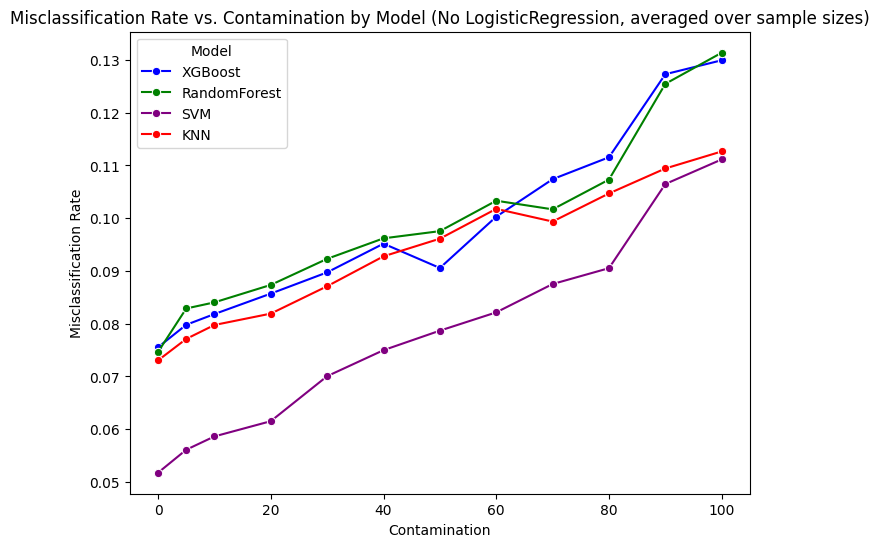

In [15]:
model_order = ["XGBoost", "RandomForest", "SVM", "KNN"]  
model_palette = {
    "XGBoost": "blue",
    "RandomForest": "green",
    "SVM": "purple",
    "KNN": "red"
}

df = pd.read_csv("results.csv")

# Filter out Logistic Regression
df = df[~df["model"].str.contains("LogisticRegression", na=False)]

# Aggregate misclassification rate over sample sizes
df_plot = df.groupby(["model", "contamination"], as_index=False)["misclassification rate"].mean()

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=df_plot,
    x="contamination",
    y="misclassification rate",
    hue="model",
    hue_order=model_order,
    palette=model_palette,
    marker="o"
)

plt.title("Misclassification Rate vs. Contamination by Model (No LogisticRegression, averaged over sample sizes)")
plt.xlabel("Contamination")
plt.ylabel("Misclassification Rate")
plt.legend(title="Model")
plt.show()

In [ ]:
model_order = ["XGBoost", "RandomForest", "SVM", "KNN"]  # Removed LogisticRegression
model_palette = {
    "XGBoost": "blue",
    "RandomForest": "green",
    "SVM": "purple",
    "KNN": "red"
}

# Filter out Logistic Regression
df = pd.read_csv("results.csv")
df = df[~df["model"].str.contains("LogisticRegression", na=False)]

sample_sizes = sorted(df["sample size (n)"].unique())

for n_val in sample_sizes:
    subset = df[df["sample size (n)"] == n_val]
    
    plt.figure(figsize=(7, 5))
    
    sns.lineplot(
        data=subset,
        x="contamination",
        y="misclassification rate",
        hue="model",
        hue_order=model_order,      
        palette=model_palette,       
        marker="o"
    )
    
    plt.title(f"Misclassification Rate vs. Contamination (n = {n_val})")
    plt.xlabel("Contamination")
    plt.ylabel("Misclassification Rate")
    plt.legend(title="Model")
    
    plt.show()